In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import gurobipy as gp
from gurobipy import GRB

In [44]:

data_dir = Path.cwd() / "Data"

df_genTech = pd.read_csv(data_dir / "TechnicalDataofGeneratingUnits-Table1.csv")
df_gen     = pd.read_csv(data_dir / "CostsandInitialStateofGeneratingUnits-Table2.csv")
df_load    = pd.read_csv(data_dir / "LoadProfile-Table3.csv")
df_demand  = pd.read_csv(data_dir / "NodeLocationandDistributionoftheTotalSystemDemand-Table4.csv")

# ---- renewables (your file is comma-delimited) ----
df_renew = pd.read_csv(data_dir / "scen_zone1.out", header=0, index_col=0)
df_renew = df_renew.apply(pd.to_numeric, errors="coerce")

U_d = [30.5, 31.2, 32.0, 32.8, 33.4,
 33.9, 34.3, 34.8, 35.2, 35.9,
 36.5, 37.1, 37.8, 38.6, 39.5,
 40.3, 41.2]

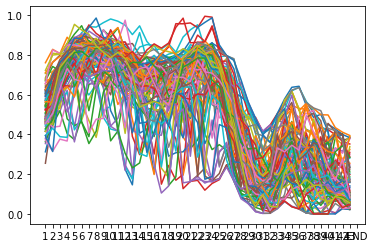

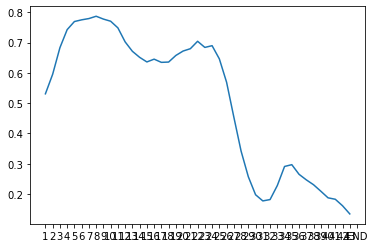

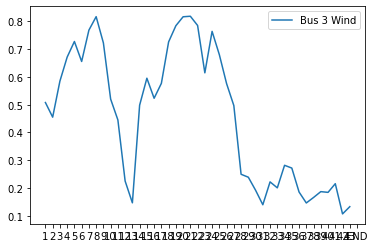

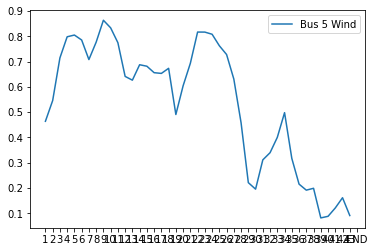

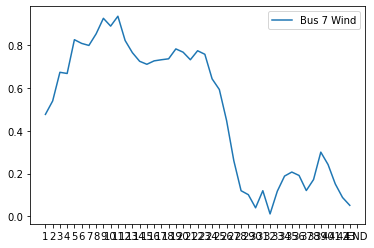

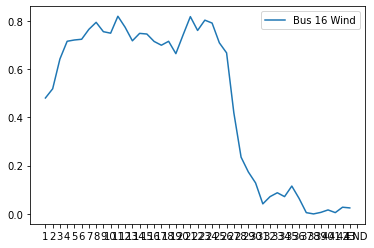

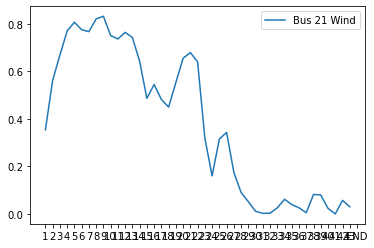

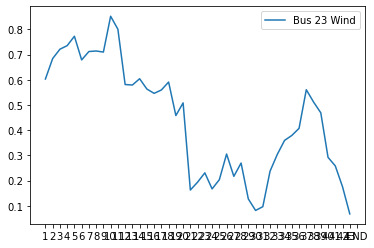

In [45]:
# If it's one big comma-separated string per row, split it
if df_renew.shape[1] == 1:
    df_renew = df_renew[0].astype(str).str.split(",", expand=True)

# Convert everything to numeric (so mean() works)
df_renew = df_renew.apply(pd.to_numeric, errors="coerce")

# Auto column names: C0, C1, C2, ...
df_renew.columns = [f"C{i}" for i in range(df_renew.shape[1])]

# Treat first column as time/index, rest as renewables
renew_cols = df_renew.columns[1:]          # all renewable columns
# If you ONLY want 6 series like before, use:
# renew_cols = df_renew.columns[1:7]

# Mean across renewables
df_renew["mean"] = df_renew[renew_cols].mean(axis=1)

# Plot all renewable series
plt.plot(df_renew[renew_cols])
plt.show()

# Plot mean
plt.plot(df_renew["mean"])
plt.show()

# Your “bus plots” style (first 6 renewable columns)
bus_cols = list(df_renew.columns[1:7])  # C1..C6
bus_labels = ["Bus 3 Wind","Bus 5 Wind","Bus 7 Wind","Bus 16 Wind","Bus 21 Wind","Bus 23 Wind"]

for col, label in zip(bus_cols, bus_labels):
    plt.plot(df_renew[col])
    plt.legend([label])
    plt.show()

In [46]:
# Initialize Gurobi model
model = gp.Model('Copperplate')

#Time of day:
time = 13

#Constants
cap_re = 200 #Capacity on the renewable generators
N_d = len(df_demand)
N_gen = len(df_genTech) # Total number of generators
N_ren = 6 # Total number of renewable generators

# Variables
Pgen = model.addVars(N_gen, vtype=gp.GRB.CONTINUOUS, name="P_gen")
Pd = model.addVars(N_d, vtype=gp.GRB.CONTINUOUS, name="P_demand")
Pw = model.addVars(N_ren, vtype = gp.GRB.CONTINUOUS, name="P_wind")


# Demand Capacity Constraints
model.addConstrs((Pd[d] <= df_demand.loc[d,"Percent"] * df_load.loc[time,"Demand"] for d in range(N_d)), name ="Demand Max Capacity")
model.addConstrs((Pd[d] >= 0 for d in range(N_d)), name ="Demand Min Capacity")

# Generator Capacity Constraints
model.addConstrs((Pgen[gen] <= df_genTech.loc[gen,"Pmax"] for gen in range(N_gen)), name ="Generator Max Capacity")
model.addConstrs((Pgen[gen] >= df_genTech.loc[gen,"Pmin"] for gen in range(N_gen)), name ="Generator Min Capacity")

# Renewable Capacity Constraints
model.addConstrs((Pw[ren] <= df_renew.iloc[time,1 + ren] * cap_re for ren in range(N_ren)), name ="Renewable Max Capacity")
model.addConstrs((Pw[ren] >= 0 for ren in range(N_ren)), name ="Renewable Min Capacity")


# Power balance constraint
model.addConstr(sum(Pgen[gen] for gen in range(N_gen))
              + sum(Pw[ren] for ren in range(N_ren)) 
              - sum(Pd[d] for d in range(N_d)) == 0, name="Power Balance")


# Objective function
model.setObjective(sum(Pd[d] * U_d[d] for d in range(N_d))
                 - sum(Pgen[gen] * df_gen.loc[gen,"Ci"] for gen in range(N_gen))
                 - sum(Pw[ren] * 0 for ren in range(N_ren)), sense=GRB.MINIMIZE)

model.update()

# Solve the optimization problem
model.optimize()
     


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[rosetta2] - Darwin 23.1.0 23B81)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 71 rows, 35 columns and 105 nonzeros
Model fingerprint: 0x26c5d6a4
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+04]
Presolve removed 71 rows and 35 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4993839e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.05 seconds (0.00 work units)
Optimal objective  2.499383850e+04


In [47]:

# -----------------------------
# Nice printing / tables
# -----------------------------
if model.status != GRB.OPTIMAL:
    print(f"Model did not solve to optimality. Status: {model.status}")
else:
    # Price from dual of power balance (absolute value avoids sign convention confusion)
    price_raw = power_balance.Pi
    price = abs(price_raw)

    # Solutions
    Pgen_sol = {g: Pgen[g].X for g in range(N_gen)}
    Pw_sol   = {w: Pw[w].X for w in range(N_ren)}
    Pd_sol   = {d: Pd[d].X for d in range(N_d)}

    total_conv = sum(Pgen_sol.values())
    total_wind = sum(Pw_sol.values())
    total_dem  = sum(Pd_sol.values())

    # Numeric welfare pieces
    benefit_val = sum(Pd_sol[d] * float(U_d[d]) for d in range(N_d))
    cost_val    = sum(Pgen_sol[g] * float(df_gen.loc[g, "Ci"]) for g in range(N_gen))
    welfare_val = benefit_val - cost_val

    def eur(x): return f"{x:,.2f}"

    print("\n" + "─"*62)
    print(f"COPPER-PLATE RESULTS (hour {time})")
    print("─"*62)
    print(f"Market price (dual of balance): {price:,.2f} €/MWh   (raw dual={price_raw:,.4f})")
    print(f"Served demand:                 {total_dem:,.2f} MW")
    print(f"Total generation:              {total_conv + total_wind:,.2f} MW   (Conv {total_conv:,.2f} | Wind {total_wind:,.2f})")
    print("─"*62)
    print(f"Consumer benefit:              {eur(benefit_val)} €/h")
    print(f"Conventional operating cost:   {eur(cost_val)} €/h")
    print(f"Social welfare:                {eur(welfare_val)} €/h")
    print("─"*62 + "\n")

    tol = 1e-6

    # Generator table
    df_g = pd.DataFrame({
        "Pg (MW)":   [Pgen_sol[g] for g in range(N_gen)],
        "Pmin (MW)": [float(df_genTech.loc[g, "Pmin"]) for g in range(N_gen)],
        "Pmax (MW)": [float(df_genTech.loc[g, "Pmax"]) for g in range(N_gen)],
        "Ci (€/MWh)":[float(df_gen.loc[g, "Ci"]) for g in range(N_gen)],
    }, index=[f"G{g}" for g in range(N_gen)])

    df_g["Profit (€/h)"] = price * df_g["Pg (MW)"] - df_g["Ci (€/MWh)"] * df_g["Pg (MW)"]

    def gen_status(r):
        if abs(r["Pg (MW)"] - r["Pmin (MW)"]) <= tol:
            return "at Pmin"
        if abs(r["Pg (MW)"] - r["Pmax (MW)"]) <= tol:
            return "at Pmax"
        if r["Pg (MW)"] > tol:
            return "marginal"
        return "off"

    df_g["Status"] = df_g.apply(gen_status, axis=1)

    # Wind table
    Wmax = {w: float(df_renew.iloc[time, 1 + w]) * cap_re for w in range(N_ren)}
    df_w = pd.DataFrame({
        "Pw (MW)":   [Pw_sol[w] for w in range(N_ren)],
        "Wmax (MW)": [Wmax[w] for w in range(N_ren)],
    }, index=[f"W{w+1}" for w in range(N_ren)])
    df_w["Curtail (MW)"] = df_w["Wmax (MW)"] - df_w["Pw (MW)"]
    df_w["Profit (€/h)"] = price * df_w["Pw (MW)"]

    # Demand table
    # Use same demand cap that you constrained with: Percent * total demand
    load_col = next(col for col in ["Demand","demand","Load","load","SystemLoad","Pload","P_Load"] if col in df_load.columns)
    total_dem_cap = float(df_load.iloc[time][load_col])

    Dmax = {d: float(df_demand.loc[d, "Percent"]) * total_dem_cap for d in range(N_d)}
    df_d = pd.DataFrame({
        "Pd (MW)":     [Pd_sol[d] for d in range(N_d)],
        "Dmax (MW)":   [Dmax[d] for d in range(N_d)],
        "Bid (€/MWh)": [float(U_d[d]) for d in range(N_d)],
    }, index=[f"D{d}" for d in range(N_d)])
    df_d["Utility (€/h)"] = df_d["Pd (MW)"] * (df_d["Bid (€/MWh)"] - price)

    def dem_status(r):
        if abs(r["Pd (MW)"] - r["Dmax (MW)"]) <= tol:
            return "at cap"
        if r["Pd (MW)"] > tol:
            return "marginal"
        return "not served"

    df_d["Status"] = df_d.apply(dem_status, axis=1)

    print("Generators")
    display(df_g.style.format({"Pg (MW)":"{:.2f}","Pmin (MW)":"{:.2f}","Pmax (MW)":"{:.2f}",
                               "Ci (€/MWh)":"{:.2f}","Profit (€/h)":"{:,.2f}"}))

    print("Wind")
    display(df_w.style.format({"Pw (MW)":"{:.2f}","Wmax (MW)":"{:.2f}","Curtail (MW)":"{:.2f}",
                               "Profit (€/h)":"{:,.2f}"}))

    print("Demand blocks")
    display(df_d.style.format({"Pd (MW)":"{:.2f}","Dmax (MW)":"{:.2f}","Bid (€/MWh)":"{:.2f}",
                               "Utility (€/h)":"{:,.2f}"}))


AttributeError: 'gurobipy.Constr' object has no attribute 'Pi'

In [ ]:

# Initialize Gurobi model
model = gp.Model('Copperplate')
    
T = len(df_load)
N_gen = len(df_genTech)

model.addVars(T, N_gen, lb = 0 , vtype=gp.GRB.CONTINUOUS, name="P_gen")




model.update()    

# Solve the optimization problem
model.optimize()
    

    


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[rosetta2] - Darwin 23.1.0 23B81)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 288 columns and 0 nonzeros
Model fingerprint: 0x9a246c76
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 288 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  0.000000000e+00
